# 1-step self-suppression

## Layout of beta

The parameter $beta$ is a $(1 + p \times N, N)$ matrix. Each column is a coefficient vector of one of $N$ neurons and
each coefficient vector consists of intercept and $p$ time-steps of coefficients of $N$ neurons.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport model 
%aimport simulation

from __future__ import division
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

from model import *
import simulation

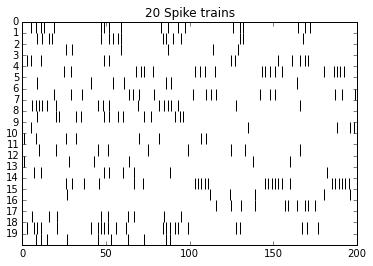

In [2]:
np.random.seed(0)

T = 200
l = 1e-4
std = 1
p = 1
L = 2
N = 20

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, l)
x = np.empty((T, L), dtype=float)
x[:T // 2, 0] = high
x[T // 2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
# a = np.empty((L, N), dtype=float)
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p * N, N))  # (1 + p)N * N matrix
b[0, :] = low
b[1:, :] = -10 * np.identity(N)

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

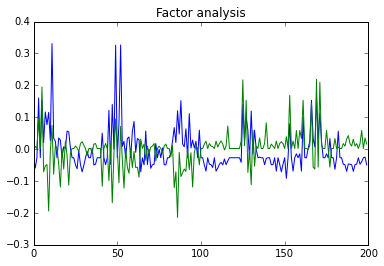

In [3]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [4]:
mu = np.zeros_like(x)
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-5,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = train(y, 1, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=False, guardSigma=False,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[1]
lower bound = -2031.69474
increment = 26947002.4123095497
change in alpha = 0.8817675178
change in beta = 0.9999988010
change in posterior mean = 0.2255992510
change in posterior covariance = 4.9941700561
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -1087.87130
increment = 943.8234420997
change in alpha = 0.7083452730
change in beta = 1.4418774529
change in posterior mean = 0.2858254846
change in posterior covariance = 0.0669638141
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -895.18713
increment = 192.6841691038
change in alpha = 0.3060735792
change in beta = 2.1097175376
change in posterior mean = 0.5595602226
change in posterior covariance = 0.0926543391
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -866.56719
increment = 28.6199406839
change in alpha = 0.1963637144
change in beta = 3.42483589

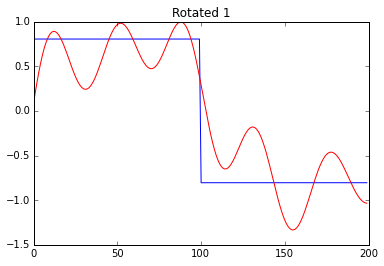

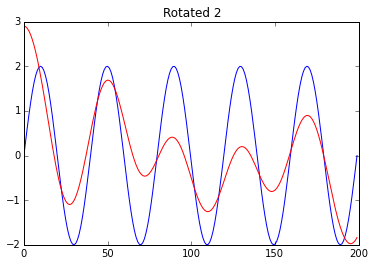

In [40]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

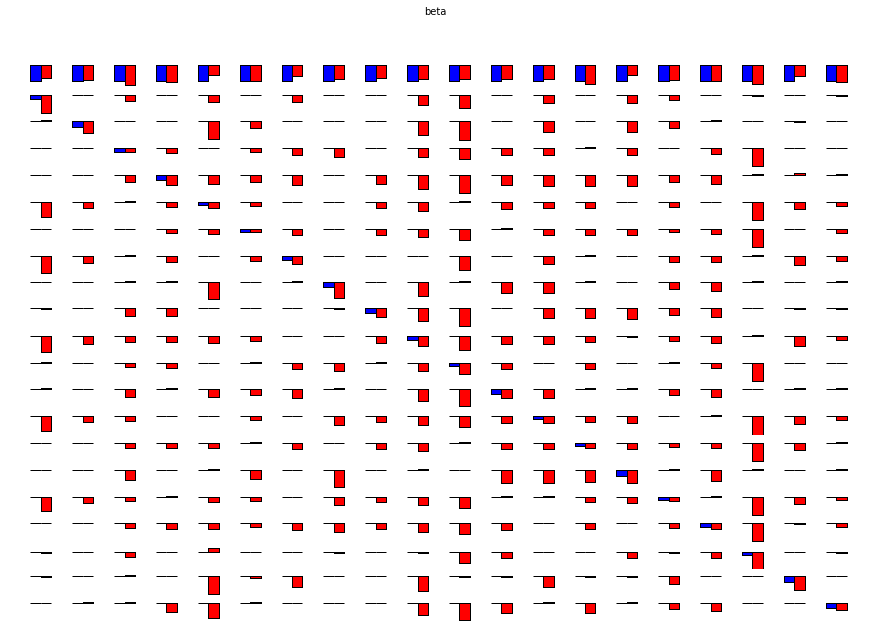

In [42]:
oldfigsize = rcParams['figure.figsize']
rcParams['figure.figsize'] = 15, 10 
_, ax = subplots(1 + p*N, sharex=True)
for row in range(1 + p*N):
    ax[row].bar(np.arange(b.shape[1]), b[row, :], width=0.25, color='blue', label='true')
    ax[row].bar(np.arange(b.shape[1]) + 0.25, b1[row, :], width=0.25, color='red', label='estimate')
    ax[row].axis('off')
suptitle('beta')
rcParams['figure.figsize'] = oldfigsize

In [12]:
b.shape

(21, 20)

In [13]:
b1.shape

(21, 20)

In [34]:
rcParams['figure.figsize'] = 15, 15 